# openEO Demonstration

## Setup

In [1]:
import os
import modules.helpers as helpers
import openeo
import xarray
import matplotlib.pyplot as pyplot

Load `eoepca state` environment

In [2]:
helpers.load_eoepca_state()
platform_domain = os.environ.get("INGRESS_HOST")
openeo_backend = f"openeo.{platform_domain}"
print(f"Using openEO backend: {openeo_backend}")

Using openEO backend: openeo.test.eoepca.org


## Connect to the openEO backend

In [3]:
connection = openeo.connect(
    url=openeo_backend,
)
connection.authenticate_oidc();

Authenticated using refresh token.


In [4]:
print("Visit this backend through Web Editor:\n" + connection.web_editor(anonymous=True))

Visit this backend through Web Editor:
https://editor.openeo.org/?server=https%3A%2F%2Fopeneo.test.eoepca.org%2Fopeneo%2F1.2%2F&discover=1


## Exploration

Available collections:

In [5]:
connection.list_collection_ids()[:10]

['TestCollection-LonLat16x16']

Available processes:

In [6]:
[p["id"] for p in connection.list_processes()[:10]]

['array_apply',
 'arccos',
 'arcosh',
 'power',
 'last',
 'subtract',
 'not',
 'cosh',
 'artanh',
 'is_valid']

## Simple processing

In [7]:
process_graph = {
    "add": {
        "process_id": "add",
        "arguments": {"x": 3, "y": 5},
        "result": True,
    },
}
connection.execute(process_graph)

8

## Raster processing

Raster processing with built-in dummy collection (which does not require direct access to actual EO data).

In [8]:
cube = connection.load_collection(
    "TestCollection-LonLat16x16",
    temporal_extent="2024-09",
    spatial_extent={"west": 3, "south": 51, "east": 5, "north": 53},
    bands=["Longitude", "Latitude", "Day"],
)

In [9]:
%%time
cube.download("openeo-lonlat1616.nc")

CPU times: user 1.97 ms, sys: 3.75 ms, total: 5.71 ms
Wall time: 820 ms


Inspect downloaded results:

In [10]:
ds = xarray.load_dataset("openeo-lonlat1616.nc")
ds;

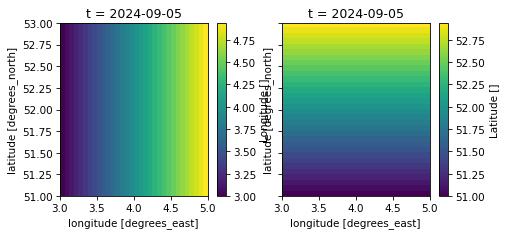

In [11]:
fig, axes = pyplot.subplots(ncols=2, figsize=(7, 3), dpi=75, sharey=True)

ds["Longitude"].isel(t=0).plot.imshow(ax=axes[0])
ds["Latitude"].isel(t=0).plot.imshow(ax=axes[1]);

## Real raster processing with `load_stac`

`load_stac` is an standard openEO process that allows to load EO data that is hosted externally through the STAC standard.

In [12]:
stac_url = "https://raw.githubusercontent.com/Open-EO/openeo-geopyspark-driver/refs/heads/master/docker/local_batch_job/example_stac_catalog/collection.json"

cube = connection.load_stac(
    url=stac_url,
    temporal_extent=["2023-06-01", "2023-06-09"],
    spatial_extent={"west": 5.07, "south": 51.215, "east": 5.08, "north": 51.22},
    bands=["B04", "B03", "B02"],
)

Simple "band math" based processing, to calculate some NDVI-like index:

In [13]:
b04 = cube.band("B04")
b02 = cube.band("B02")
n42 = (b04 - b02) / (b04 + b02)

Trigger processing and download result synchronously:

In [14]:
%%time
n42.download("openeo-load_stac-n42-sync.nc")

CPU times: user 2.81 ms, sys: 1.92 ms, total: 4.73 ms
Wall time: 1.49 s


Inspect result:

In [15]:
ds = xarray.load_dataset("openeo-load_stac-n42-sync.nc")
ds;

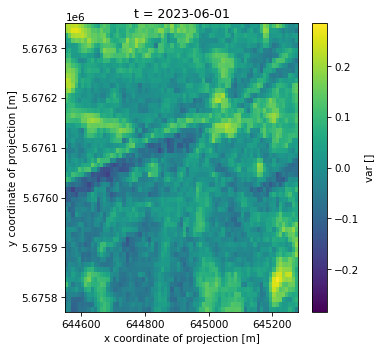

In [16]:
fig, ax = pyplot.subplots(dpi=75, figsize=(5, 5))
ds["var"].isel(t=0).plot.imshow(ax=ax, cmap="viridis");